# EDA for News Headlines Dataset For Sarcasm Detection 
#### Скачивание всех необходимых библиотек, словарей и настроек

In [39]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import re
import nltk
import spacy
import statistics
from plotly.offline import init_notebook_mode
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

tqdm.pandas()
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18
spacy_eng = spacy.load("en_core_web_sm")
stop_words = stopwords.words('english')
stop_words.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vadimka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Загрузка частей датасета и первоначальная обработка

In [35]:
data1 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]
data = pd.concat([data1,data2])
df = data.sample(frac=1)
df.reset_index(drop=True, inplace=True)

In [36]:
df.head(5)

headline  is_sarcastic
0  want to pass bills in the texas legislature? t...             0
1            wow: erykah badu shares steamy sex tips             0
2                       man calls trust fund savings             1
3  friend who's into politics makes you feel stup...             1
4                   bush extremely proud of new suit             1

#### Проверка датасета

In [16]:
df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [19]:
df[(df["headline"] == '') | (df["headline"] == ' ')]

Empty DataFrame
Columns: [headline, is_sarcastic]
Index: []

In [20]:
df[(df["is_sarcastic"] != 0) & (df["is_sarcastic"] != 1)]

Empty DataFrame
Columns: [headline, is_sarcastic]
Index: []

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 864.6+ KB


#### Распределение is_sarcastic

C:\Users\Vadimka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Распределение is_sarcastic')

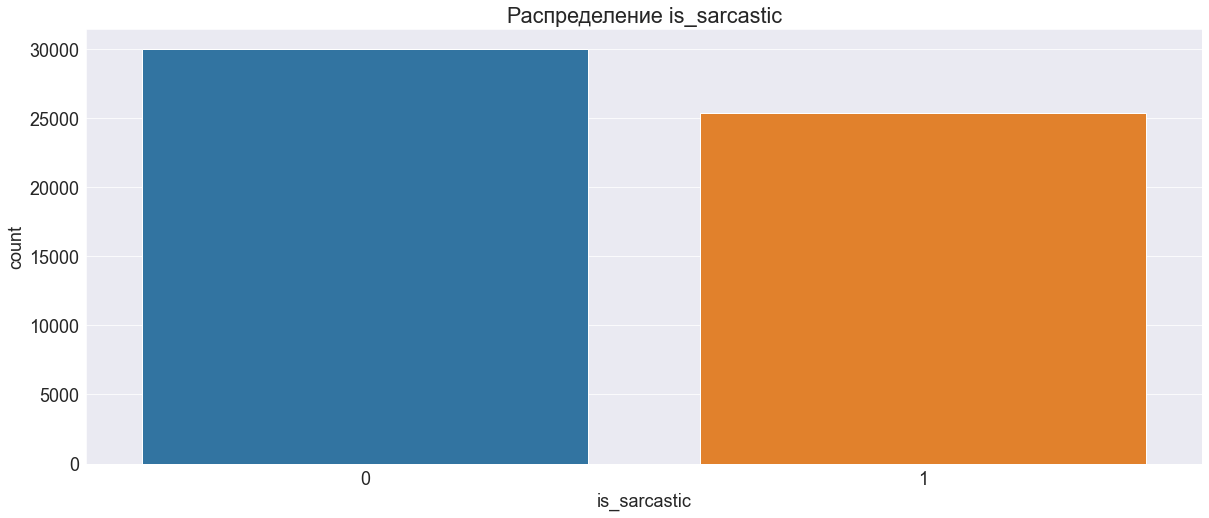

In [29]:
sns.countplot(df.is_sarcastic).set_title('Распределение is_sarcastic')

#### Распределения по текстовым характеристкам

In [32]:
df['cnt_words'] = df['headline'].apply(lambda x: len(x.split()))
df['cnt_symbols'] = df['headline'].apply(lambda x: len(x))
df['avg_symbols'] = df['headline'].apply(lambda x: statistics.mean([len(word) for word in x.split()]))

df.head(5)

headline  is_sarcastic  cnt_words  \
0  americans gave record $373.25 billion to chari...             0          9   
1  new 'time' to keep everything from happening a...             1          9   
2  police headquarters completes new addition to ...             1         13   
3         jerry falwell: is that guy a dick or what?             1          9   
4  san francisco makes a major statement against ...             0         12   

   cnt_symbols  avg_symbols  
0           58     5.555556  
1           52     4.888889  
2           94     6.307692  
3           42     3.777778  
4           78     5.583333

In [26]:
px.histogram(
    df, 
    x="cnt_symbols",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по длине текста", 
    marginal="box"
)

In [27]:
px.histogram(
    df, 
    x="cnt_words",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по кол-ву слов", 
    marginal="box"
)

In [33]:
px.histogram(
    df, 
    x="avg_symbols",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по средней длине слова в заголовке", 
    marginal="box"
)

###  Обработка текста
- Удаление ненужных символов
- Лемматизация слов
- Удаление stopwords 
- Удаление приставок для ссылок
- Приведение в нижний регистр
- Нахождение тематики текста: DATE/TIME/CARDINAL

In [83]:
def text_processing(text):
    
    headline = re.sub('\s+\n+', ' ', text)
    headline = re.sub(r'[^\w\s]', '', headline)
    headline = re.sub(r"\''", '', headline)
    headline = re.sub(r'http\S+', '', headline)
    headline = headline.lower()
    
    headline = ' '.join([word for word in headline.split() if not word in stop_words])
    headline = ' '.join([token.lemma_ for token in spacy_eng(headline)])
       
    return headline

def get_entities(text):
    entities = []
    spacy_eng_by_text = spacy_eng(text)
    for word in spacy_eng_by_text.ents:
        entities.append(word.label_)
        
    return list(set(entities))

In [94]:
df['processed_headline'] = df['headline'].progress_apply(text_processing)
df['entities'] = df['processed_headline'].progress_apply(get_entities)

100%|██████████| 650/650 [00:20<00:00, 31.62it/s]


In [95]:
df.head(5)

headline  is_sarcastic  \
47029  robert pattinson & fka twigs spend time at cha...             0   
26613        bananas again sweep primates' choice awards             1   
24607       terrified glob of cream cheese escapes bagel             1   
50621  border wall prototype clearly designed by yayo...             1   
1436   candidate to accuse opponent of racism just to...             1   

                                      processed_headline  entities  \
47029  robert pattinson fka twig spend time chateau m...  [PERSON]   
26613                  banana sweep primate choice award  [PERSON]   
24607             terrify glob cream cheese escape bagel        []   
50621  border wall prototype clearly design yayoi kusama        []   
1436         candidate accuse opponent racism see happen        []   

       cnt_words_processed  cnt_symbols_processed  avg_symbols_processed  \
47029                    8                     52               5.625000   
26613                    5                     33               5.800000   
24607                    6                     38               5.500000   
50621                    7                     49               6.142857   
1436                     6                     43               6.333333   

       cnt_stopwords list_of_entities  
47029              1         [PERSON]  
26613              1         [PERSON]  
24607              1               []  
50621              1               []  
1436               5               []

#### Распределения по текстовым характеристкам для обработанного текста

In [96]:
df['cnt_words_processed'] = df['processed_headline'].apply(lambda x: len(x.split()))
df['cnt_symbols_processed'] = df['processed_headline'].apply(lambda x: len(x))
df['avg_symbols_processed'] = df['processed_headline'].apply(lambda x: statistics.mean([len(word) for word in x.split()]))
df['cnt_stopwords'] = df['headline'].apply(lambda x: len([len(word) for word in x.split() if word in stop_words]))

In [97]:
px.histogram(
    df, 
    x="cnt_words_processed",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по длине текста", 
    marginal="box"
)

In [98]:
px.histogram(
    df, 
    x="cnt_symbols_processed",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по кол-ву слов", 
    marginal="box"
)

In [99]:
px.histogram(
    df, 
    x="avg_symbols_processed",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по кол-ву слов", 
    marginal="box"
)

In [100]:
px.histogram(
    df, 
    x="cnt_stopwords",
    height=400, 
    color='is_sarcastic', 
    title="Распределение по кол-ву слов", 
    marginal="box"
)

In [102]:
df.drop(df[df['cnt_words_processed'] > 30].index, inplace = True)
df.reset_index(inplace=True, drop=True)

#### Распределения с точки зрения entities

In [114]:
flattened_df = df.explode('entities')

px.histogram(
    flattened_df, 
    x="entities",
    height=300, 
    color='is_sarcastic', 
    title="Распределения с точки зрения entities"
)

In [116]:
flattened_df[flattened_df['entities'] == 'DATE'].sample(3)

headline  is_sarcastic  \
485  millennium actually starts in 2001, terrorists...             1   
304  celebrities celebrate fourth of july with some...             0   
579      friday talking points -- gop anti-trump rants             0   

                                processed_headline entities  \
485  millennium actually start 2001 terrorist note     DATE   
304        celebrity celebrate fourth july fun sun     DATE   
579        friday talking point gop antitrump rant     DATE   

     cnt_words_processed  cnt_symbols_processed  avg_symbols_processed  \
485                    6                     45               6.666667   
304                    6                     39               5.666667   
579                    6                     39               5.666667   

     cnt_stopwords list_of_entities  
485              1           [DATE]  
304              5           [DATE]  
579              0     [DATE,, ORG]

In [117]:
flattened_df[flattened_df['entities'] == 'GPE'].sample(3)

headline  is_sarcastic  \
269     impatient raytheon declares war on north korea             1   
228  california to release all prisoners who seem n...             1   
382  robert mueller dreading returning from 2-month...             1   

                                    processed_headline entities  \
269         impatient raytheon declare war north korea      GPE   
228       california release prisoner seem nice enough      GPE   
382  robert mueller dreading return 2month european...      GPE   

     cnt_words_processed  cnt_symbols_processed  avg_symbols_processed  \
269                    6                     42               6.166667   
228                    6                     44               6.500000   
382                   10                     82               7.300000   

     cnt_stopwords                  list_of_entities  
269              1                             [GPE]  
228              3                             [GPE]  
382              2  [NORP,, PERSON,, GPE,, CARDINAL]

###  Визуализация с помощью Word Clouds

In [118]:
sarcastic_list_words = df[df['is_sarcastic']==1]['processed_headline'].tolist()
genuine_list_words = df[df['is_sarcastic']==0]['processed_headline'].tolist()

#### Наиболее часто встречаемые слова для саркастичных новостных заголовков

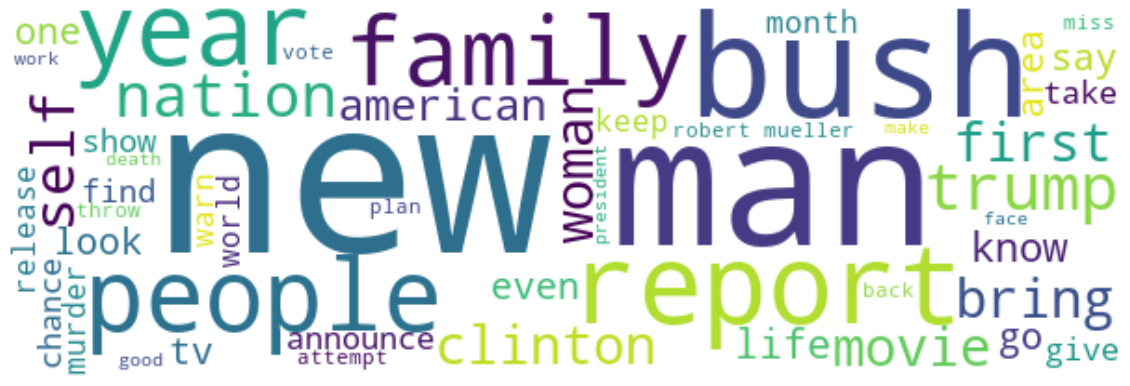

In [119]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(sarcastic_list_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Наиболее часто встречаемые слова для честных новостных заголовков

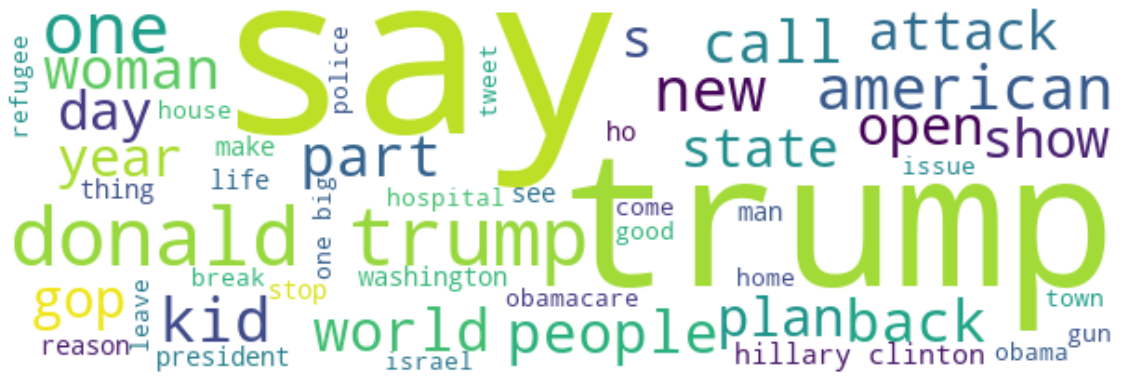

In [120]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(genuine_list_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()